In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('./molecular-state-classes-and-functions/')

In [91]:
import pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from collapse_functions import collapse_matrices
from density_functions import generate_density_matrix
from state_functions import find_exact_states, calculate_BR
from hamiltonian_functions import reduced_basis_hamiltonian
from classes import UncoupledBasisState, CoupledBasisState, State
from functions import make_hamiltonian, make_hamiltonian_B, ni_range, matrix_to_states, vector_to_state,\
                      find_state_idx_from_state, make_transform_matrix
from laser_functions import optical_coupling_matrix, ED_ME_mixed_state, calculate_power_needed, laser_field

## X State Hamiltonian

In [14]:
H_X_uc = make_hamiltonian("./stored_data/TlF_X_state_hamiltonian_J0to4.pickle")

In [17]:
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [18]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./stored_data/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [19]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [25]:
D, V = np.linalg.eigh(H_X)

# Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

# Remove very small entries from V
# V[np.abs(V) < 1e-5] = 0

# New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)

In [28]:
# Define what states are to be included in the simulation
Js_g = [0,1,2]
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag)

In [31]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

# Set small off diagonal terms to zero
H_X_red[np.abs(H_X_red) < 0.1] = 0

## B State Hamiltonian

In [32]:
H_B = make_hamiltonian_B("./stored_data/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [33]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [37]:
D,V = np.linalg.eigh(H_B)

# Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

# New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)

In [38]:
# Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag)

In [39]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Optical Couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [40]:
# Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

# Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = find_exact_states(ground_states_laser_approx, H_X_diag, QN_X_diag)

#Excited states for laser
excited_states_laser = excited_states

In [44]:
%%time
# Coupling laser for z-polarized
H_laser_z = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                             reduced = False)
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_z, H_laser_z.conj().T))

# Check number of couplings added
print(H_laser_z[np.abs(H_laser_z)>0].shape)

True
(16,)
Wall time: 35.3 s


In [45]:
%%time
H_laser_x = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([1,0,0]), 
                                             reduced = False)
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_x, H_laser_x.conj().T))

# Check number of couplings added
print(H_laser_x[np.abs(H_laser_x)>0].shape)

True
(32,)
Wall time: 34.9 s


In [48]:
# Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate

# Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

# Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

## Collapse Operators

In [49]:
Gamma = 1/100e-9 # 2*pi [Hz]

In [50]:
excited_test_approx = 1*CoupledBasisState(J = 1, F1=3/2, F=1, mF=0, I1=1/2, I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_test_i = find_state_idx_from_state(H_B_diag,excited_test_approx, QN_B_diag)
excited_test = QN_B_diag[excited_test_i]

ground_test_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_test_i = find_state_idx_from_state(H_X_diag,ground_test_approx, QN_X_diag)
ground_test = QN_X_diag[ground_test_i]

BRs = calculate_BR(excited_test, ground_states)

In [51]:
C_array = collapse_matrices(QN, ground_states, excited_states, gamma = Gamma)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

## Density Matrix

In [52]:
# Define states that are populated initially
Js = [0,1,2]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])
    
pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

In [53]:
import scipy.constants as cst

def boltzmann_distribution(rot_constant, temperature, J_list):
    init = np.zeros(len(J_list))
    Z = 0
    g = 1
    for J in J_list:
        g = 4*(2*J+1)
        Z += g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))
    for idx, J in enumerate(J_list):
        g = 4*(2*J+1)
        init[idx] = g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))/Z
    return init

In [54]:
B_0 = 6.68667*1e9 # Hz
T = 7
boltz_dist = boltzmann_distribution(B_0,T, np.arange(0,150,1))

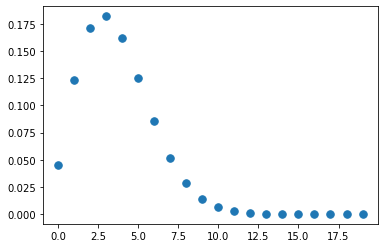

In [57]:
plt.plot(boltz_dist[:20], '.', ms = 15)

In [58]:
def get_J_indices(J_list):
    spans = []
    for J in J_list:
        spans.append(4*(2*J+1))
    indices = [(0,spans[0])]
    for idx,span in enumerate(spans[1:]):
        s = np.sum(spans[:idx+1])
        indices.append((s, s+span))
    return indices

In [59]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    print(idx, idx_max-idx_min, boltz_dist[idx]/(idx_max-idx_min))
    np.fill_diagonal(rho_ini[sl], boltz_dist[idx]/(idx_max-idx_min))
rho_ini /= np.diag(rho_ini).sum()

0 4 0.011286978903789161
1 12 0.01029811954327005
2 20 0.008572714492675116


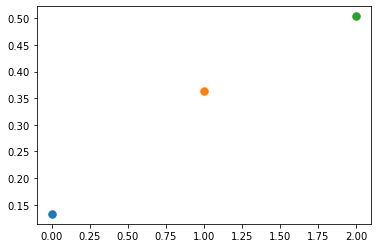

In [60]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    plt.plot(idx, np.sum(np.diag(rho_ini[sl])).real, '.', ms = 15)

## Setting Up ODE Function

In [83]:
def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [84]:
# Generate optical coupling matrix with set rabi rate
Omega = np.abs(4.5*Gamma*ME_main)

# Define frequency for polarization switching
omega_p = Gamma
wp = omega_p/(2*np.pi)

H_oc_t = lambda t: (Omega/ME_main/2)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))

H_oc = Omega*H_laser_z/ME_main

In [85]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [86]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [123]:
# rhs of the Lindblad equation
opt = 'greedy'
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
           -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                   + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()
    
    
    return rhs.flatten()

In [115]:
%%timeit
Lindblad_rhs(1e-6,rho_ini.flatten())

2.97 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


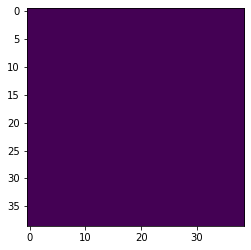

In [122]:
plt.imshow(Lindblad_rhs(1e-6,rho_ini.flatten()).real.reshape(rho_ini.shape))

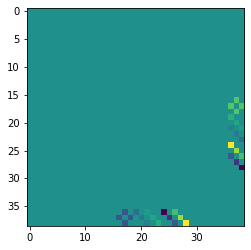

In [121]:
plt.imshow(Lindblad_rhs(1e-6,rho_ini.flatten()).imag.reshape(rho_ini.shape))

## Speed testing some optimizations for Lindblad_rhs
The first line is
```python
(-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t))
```
and the only way to get significant speedups here is by optimizing Hamiltonian(t).  
Subsequently 
```python
np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
```
is calculated. The `opt` parameter is set to greedy, which significantly speeds up the computation:

In [124]:
# generate a random
_x = np.random.random(rho_ini.shape).astype('complex')
opt = 'greedy'

In [125]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array,optimize = opt)

683 µs ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [126]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array)

294 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


around a factor 430 faster computation.  
It is also possible to precalculate the optimization path:

In [130]:
# precalculating the optimum multiplication path
path = np.einsum_path('ijk,kl,ilm',C_array, _x, C_conj_array, optimize='optimal')[0]

In [131]:
%%timeit
np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array,optimize = path)

624 µs ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


But this doesn't result in any speedup over using the `greedy` optimization.  

Precompiling the function with numba:

In [132]:
# naive replacement using numba
from numba import njit

@njit
def multi_faster(result, C, C_conj, rho):
    r1 = C.shape[0]
    r2 = C.shape[1]
    
    for j in range(r2):
        for m in range(r2):
            for i in range(r1):
                for k in range(r2):
                    for l in range(r2):
                        result[j,m] += C[i,j,k]*rho[k,l]*C_conj[i,l,m]

In [133]:
%%timeit
# naive replacement using numba
result = np.zeros(_x.shape, dtype = 'complex')
multi_faster(result, C_array, C_conj_array, _x)

158 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is only slightly faster than using unoptimized `einsum`, and significantly slower than einsum with the `opt` parameter.

Now using the numpy dot product while using a for loop over the first axis of the arrays:

In [134]:
%%timeit
# replace einsum with a for loop and matrix product
# fastest for Jmax > 2
s = np.zeros(rho_ini.shape, dtype = 'complex')
for idx in range(C_array.shape[0]):
    s += C_array[idx]@_x@C_conj_array[idx]

792 µs ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The overhead for the python for loop results in it being slightly slower than optimized einsum for $J\leq 2$, but when $J>2$ the speedup from using the numpy dot product overcomes this overhead. The numpy dot product uses Intel MKL if possible, which automatically uses multiple cores to do matrix operations, which einsum does not do.

Finally we can also multiply the matrices and then sum over the first axis:

In [135]:
%%timeit
# replace einsum with a matrix mult and sum
(C_array@_x@C_conj_array).sum(axis = 0)

531 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Because of the way `C_conj_array` was made (with `einsum`) the array is not layed out C contiguous in memory which might slow down computation a bit. Making `C_conj_array` C contiguous:

In [184]:
_t = np.ascontiguousarray(C_conj_array)

In [185]:
%%timeit
# replace einsum with a matrix mult and sum
(C_array@_x@_t).sum(axis = 0)

506 µs ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Which is the fastest option for $J\leq 2$.

Using numpy for the dot product and `einsum` for the sum:

In [186]:
%%timeit
# replace einsum with a matrix mult and einsum
# fastest for Jmax <= 2
np.einsum('ijk->jk',C_array@_x@C_conj_array)

509 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [187]:
%%timeit
# replace einsum with a matrix mult and einsum
# fastest for Jmax <= 2
np.einsum('ijk->jk',C_array@_x@_t)

464 µs ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The numpy sum has a small overhead due to checks to function performs on input variables, which results in a slight speedup using `einsum`.

In [71]:
# replace einsum witha numba @njit function
result = np.zeros(_x.shape, dtype = 'complex')
multi_faster(result, C_array, C_conj_array, _x)
np.array_equal(result, np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array))

True

In [72]:
# replace einsum with a for loop
s = np.zeros(rho_ini.shape, dtype = 'complex')
for idx in range(C_array.shape[0]):
    s += C_array[idx]@_x@C_conj_array[idx]
np.array_equal(np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array), s)

True

In [73]:
# replace einsum with a matrix mult and sum
np.array_equal(np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array), (C_array@_x@C_conj_array).sum(axis = 0))

True

In [74]:
# replace einsum with a matrix mult and einsum
np.array_equal(np.einsum('ijk->jk',C_array@_x@C_conj_array), np.einsum('ijk,kl,ilm',C_array, _x, C_conj_array))

True

Now looking at 
```python
np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
```

In [75]:
%%timeit
np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x, optimize = opt)

261 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Because `C_conj_array` and `C_array` don't change we can precompute that multiplication:

In [76]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

In [77]:
%%timeit
Cprecalc@_x

8.48 µs ± 446 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


resulting in a factor 30 speedup.

In [78]:
# not the same result
print(np.array_equal(np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x), Cprecalc@_x))
print(np.array_equal(np.einsum('jk,ikl,ilm', _x, C_conj_array, C_array), _x@Cprecalc))

False
False


In [79]:
# but within 1e-8, within rounding error
print(np.all(np.isclose(np.einsum('ijk,ikl,lm', C_conj_array, C_array, _x), Cprecalc@_x, 1e-8)))
print(np.all(np.isclose(np.einsum('jk,ikl,ilm', _x, C_conj_array, C_array), _x@Cprecalc, 1e-8)))

True
True


# Now checking for Jmax = 3

In [181]:
C_conj_array

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False